In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
from matplotlib import rc
from matplotlib.dates import DateFormatter

rc('text', usetex=True)
rc('text.latex', preamble=r'\usepackage{cmbright}')
rc('font', **{'family': 'sans-serif', 'sans-serif': ['Helvetica']})

%matplotlib inline

# This enables SVG graphics inline. 
%config InlineBackend.figure_formats = {'png', 'retina'}

rc = {'lines.linewidth': 2, 
      'axes.labelsize': 18, 
      'axes.titlesize': 18, 
      'axes.facecolor': 'DFDFE5'}
sns.set_context('notebook', rc=rc)
sns.set_style("dark")

mpl.rcParams['xtick.labelsize'] = 16 
mpl.rcParams['ytick.labelsize'] = 16 
mpl.rcParams['legend.fontsize'] = 14

In [49]:
df = pd.read_csv('cdc_state_counts.csv')
df.date = pd.to_datetime(df.date)
df['freq'] = df.outcome / df.population
df['SmoothFreq'] = df.groupby('state').freq.transform(lambda x:
                                                                x.rolling(window=2,
                                                                          win_type='gaussian',
                                                                          center=True).mean(std=2))
df['RefTime'] = df.groupby(pd.Grouper(key='date',freq='YS')
                             ).date.transform(lambda x:
                                         (x - x.min()) / dt.timedelta(days=1))

prev = df[df.date < dt.datetime(2020, 1, 1)]
df.tail()

,state,date,outcome,population,freq,SmoothFreq,RefTime
9516,Wyoming,2020-05-23,100,579796.441096,0.000172,0.000175,140.0
9517,Wyoming,2020-05-30,80,579818.649315,0.000138,0.000155,147.0
9518,Wyoming,2020-06-06,102,579840.857534,0.000176,0.000157,154.0
9519,Wyoming,2020-06-13,87,579863.065753,0.000150,0.000163,161.0
9520,Wyoming,2020-06-20,71,579885.273973,0.000122,0.000136,168.0


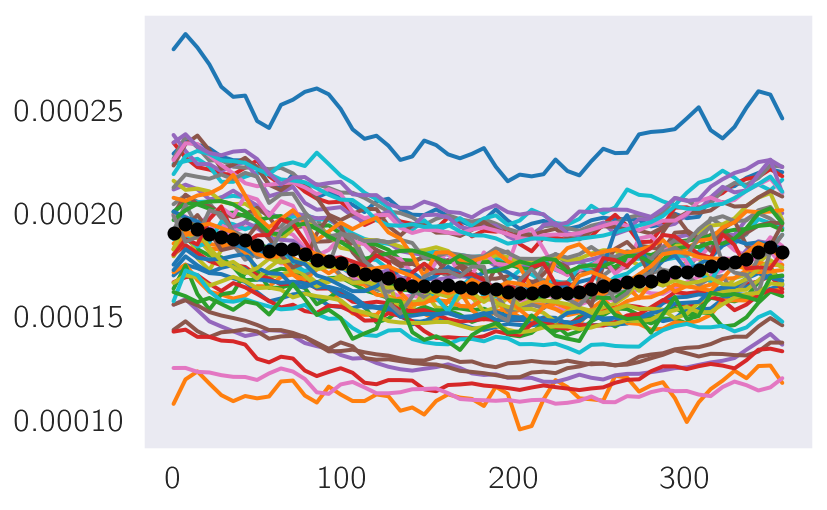

In [50]:
mean_death = prev.groupby(['state', 'RefTime']).apply(np.mean)
mean_death = mean_death[['SmoothFreq', 'outcome', 'population']]
mean_death.reset_index(inplace=True)
mean_death.head()

for n, g in mean_death.groupby('state'):
    plt.plot(g.RefTime, g.SmoothFreq)

plt.plot(mean_death.RefTime.unique(), mean_death.groupby('RefTime').SmoothFreq.apply(np.mean), 'o', color='black', zorder=np.inf)

141 thousand people dead


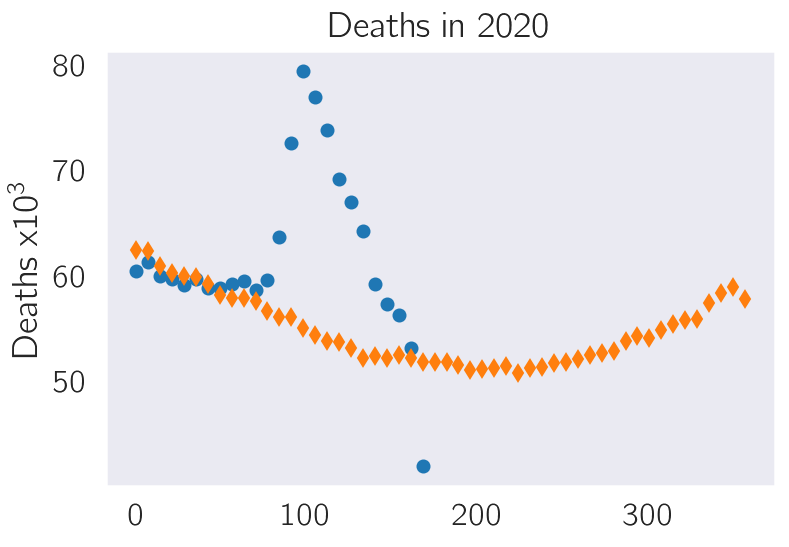

In [71]:
y = df[df.date >= dt.datetime(2020, 1, 1)].groupby('RefTime').outcome.sum()
y2 = mean_death.groupby('RefTime').outcome.sum()

x = df[df.date >= dt.datetime(2020, 1, 1)].RefTime.unique()
x2 = mean_death.RefTime.unique()

plt.plot(x, y / 1000, 'o')
plt.plot(x2, y2 / 1000, 'd')

plt.ylabel('Deaths x$10^3$')
plt.title('Deaths in 2020')

excess = (y.sum() - y2[x2 <= x[-1]].sum())

print('{0:.0f} thousand people dead'.format(excess / 10 ** 3))